简述

有些策略会使用到多周期的数据，典型的应用为：

使用周线（大周期）数据判断趋势

使用日线（小周期）数据判断买卖点

这就需要同时读入多周期数据进行回测

回测时需要遵循以下规则：

小周期数据必须被第一个加入到Cerebro实例中

第一个被添加的数据将被作为时钟数据，因此需要将小周期数据首先添加到系统中，以使得小力度的时间都能被遍历到。

数据必须按照日期时间做好对齐，这样才能正确地使用数据

在回测过程中，不会对时间进行重新排序，只能按照整理好的数据顺序依次处理，因此需要将不同周期的数据都做好对齐。

大周期数据的使用会使得策略的最小周期变大。

如果要计算出技术指标的有效值，至少需要若干根K线数据，例如：计算5日均线，则至少需要前5根日K线，才能计算出第一个有效值，也就是至少经过5日，这里的5日就是最小周期。不同指标可能具有不同的最小周期，单周期回测时，策略的最小周期就是所有指标最小周期的最大值。而多周期回测中，最小周期则变得复杂。通常，要计算出大周期技术指标的有效值，策略的最小周期会变大，也就是回测开始后，要经过更多的K线来保证大周期技术指标能够计算出第一个有效值

策略将先读入日线数据，再读入周线数据。回测股票为000001平安银行，回测周期为2018年1月1日至2019年12月31日。

买入条件：日MACD金叉、周RSI小于50；卖出条件：价格较最高收盘价回撤5%卖出

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


2018-03-12 BUY 000001.XSHE EXECUTED, Price: 1405.95
2018-03-23 SELL 000001.XSHE EXECUTED, Price: 1301.80
2018-04-11 BUY 000001.XSHE EXECUTED, Price: 1318.01
2018-04-16 SELL 000001.XSHE EXECUTED, Price: 1300.47
2018-05-15 BUY 000001.XSHE EXECUTED, Price: 1293.70
2018-05-25 SELL 000001.XSHE EXECUTED, Price: 1222.42
2018-06-19 BUY 000001.XSHE EXECUTED, Price: 1162.95
2018-06-25 SELL 000001.XSHE EXECUTED, Price: 1089.41
2018-07-11 BUY 000001.XSHE EXECUTED, Price: 1013.67
2018-08-02 SELL 000001.XSHE EXECUTED, Price: 1051.40
2019-01-08 BUY 000001.XSHE EXECUTED, Price: 1143.16
2019-03-08 SELL 000001.XSHE EXECUTED, Price: 1459.90
2019-06-11 BUY 000001.XSHE EXECUTED, Price: 1449.80
2019-06-25 SELL 000001.XSHE EXECUTED, Price: 1540.26
2019-12-12 BUY 000001.XSHE EXECUTED, Price: 1859.24
Final Portfolio Value: 1181186.60


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.13,2018-03-09,2018-06-22,2019-02-25,252
1,4.80,2019-06-20,2019-12-11,2019-12-17,129
2,2.51,2019-03-06,2019-03-07,2019-06-19,76
3,0.00,2019-02-25,2019-02-25,2019-02-25,1
4,0.00,2019-02-25,2019-02-25,2019-02-25,1


Stress Events,mean,min,max
New Normal,0.04%,-4.16%,8.40%


Top 10 long positions of all time,max
000001.XSHE,99.53%


Top 10 short positions of all time,max


Top 10 positions of all time,max
000001.XSHE,99.53%
000001.XSHE,0.00%


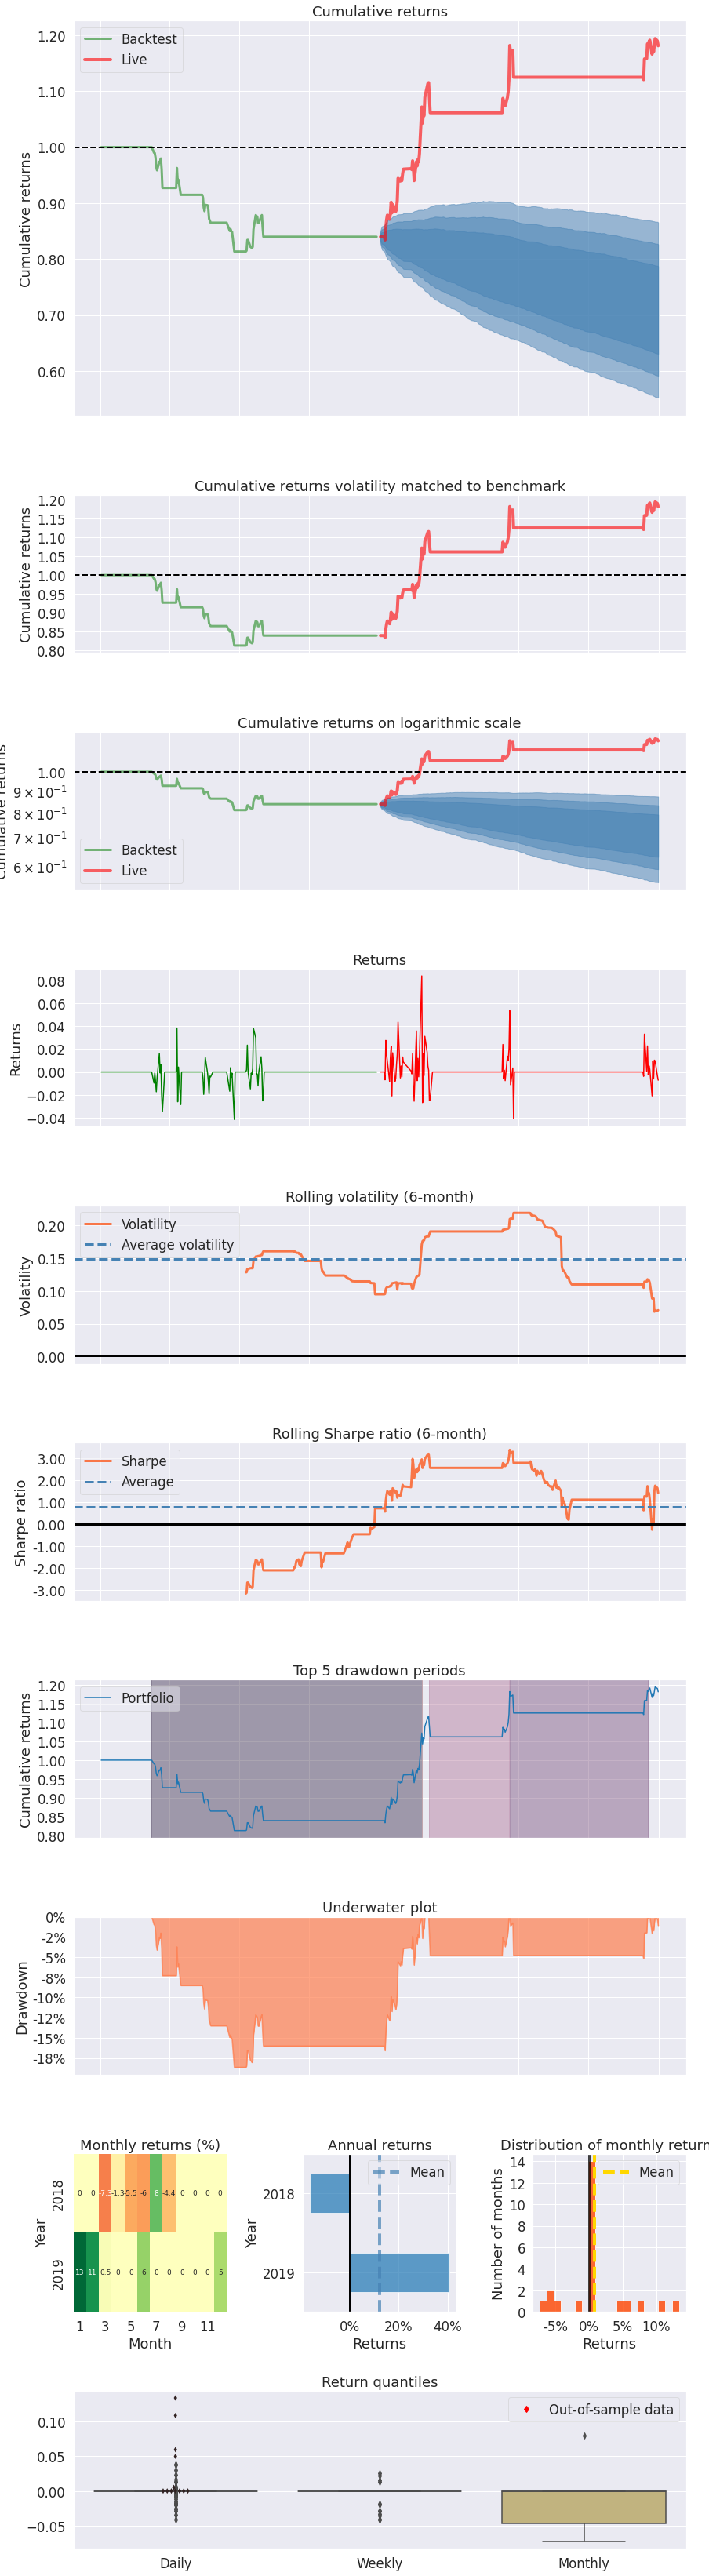

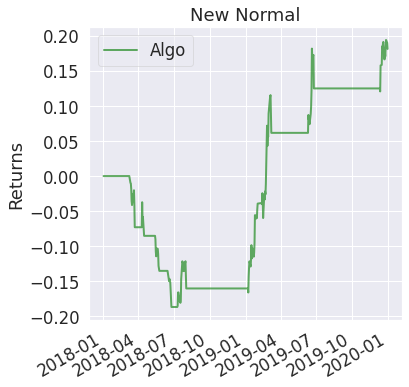

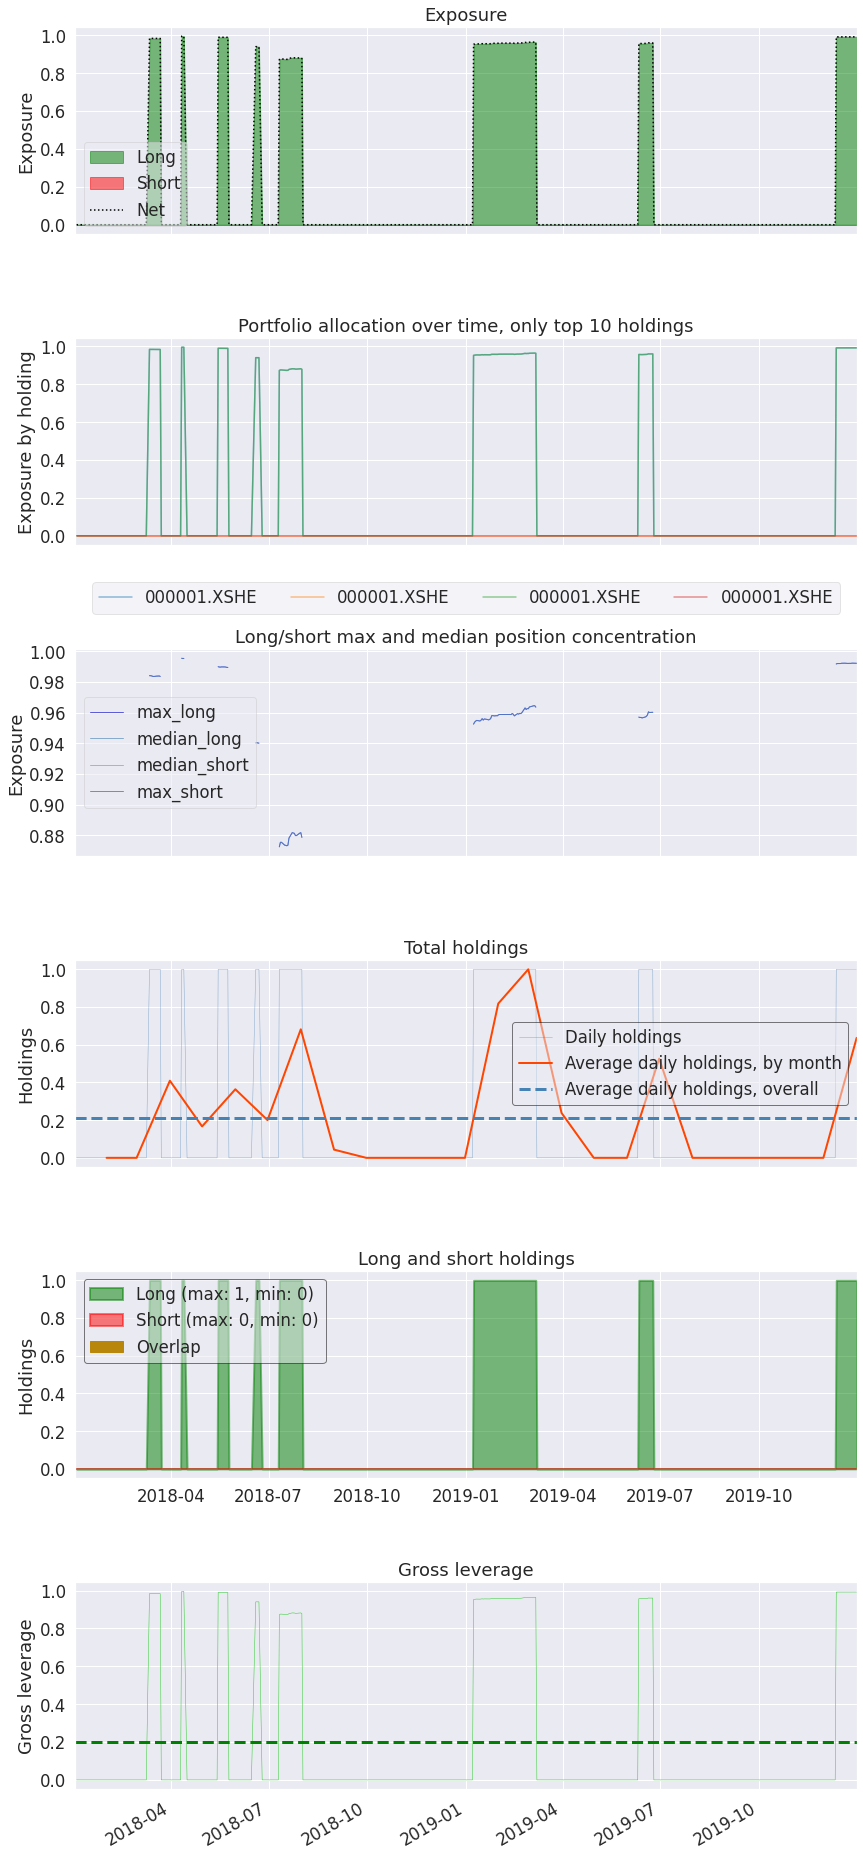

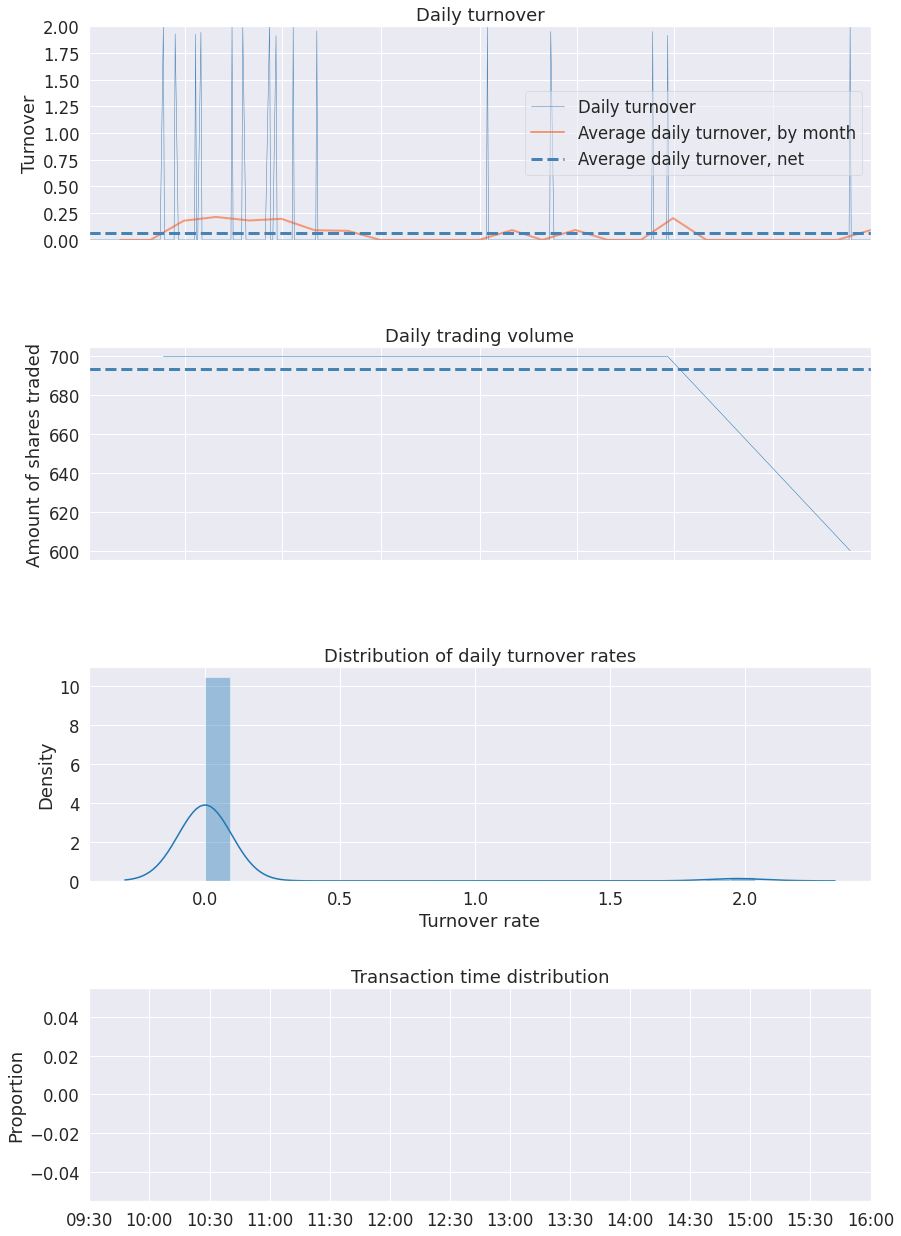

In [2]:
# 多周期
# 买入条件：日MACD金叉、周RSI小于50
# 卖出条件：价格较最高收盘价回撤5%卖出
import backtesting as bt
import backtesting.feeds as btfeeds
import backtesting.indicators as btind
import datetime
import pandas as pd
from collections import defaultdict
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')

class RSIMACDMultiTF(bt.Strategy):
    params = (
        ('trailamount', 0.0),
        ('trailpercent', 0.05),
    )

    def __init__(self):
        # 存储不同数据的技术指标
        self.inds = dict()
        # 存储特定股票的订单，key为股票的代码
        self.orders = dict()
        # 遍历所有数据
        for i, d in enumerate(self.datas):
            self.orders[d._name] = None
            # 为每个数据定义字典，存储技术指标
            self.inds[d] = dict()
            # 判断d是否为日线数据
            if 0 == i % 2:
                self.inds[d]['crossup'] = btind.CrossUp(btind.MACD(d).macd, btind.MACD(d).signal)
            # d为周线数据
            else:
                self.inds[d]['rsi'] = btind.RSI_Safe(d)

    def next(self):
        #print(self.datetime.date())
        for i, d in enumerate(self.datas):
            # 如果处理周线数据则跳过买卖条件，因为已在日线数据判断处理过
            if 1 == i % 2:
                continue
            pos = self.getposition(d)
            # 不在场内，则可以买入
            if not len(pos):
                # 达到买入条件
                if self.inds[d]['crossup'][0] and self.inds[self.datas[i + 1]]['rsi'][0] < 50:
                    # 买入手数，如果是多只股票回测，这里需要修改
                    stake = int(self.broker.cash // (d.close[0] * 100)) * 100
                    # 买买买
                    self.buy(data = d, size = stake)
            elif not self.orders[d._name]:
                # 下保护点卖单
                self.orders[d._name] = self.close(data = d, exectype= bt.Order.StopTrail,
                            trailamount=self.p.trailamount,
                            trailpercent=self.p.trailpercent)

    def notify_order(self, order):

        if order.status in [order.Completed]:
            if order.isbuy():
                print('{} BUY {} EXECUTED, Price: {:.2f}'.format(self.datetime.date(), order.data._name, order.executed.price))
            else:  # Sell
                self.orders[order.data._name] = None
                print('{} SELL {} EXECUTED, Price: {:.2f}'.format(self.datetime.date(), order.data._name, order.executed.price))

# 加载数据
def load_data(data_info):
    fromdate = datetime.datetime(2018, 1, 1)
    todate = datetime.datetime(2019, 12, 31)
    datapath = "./stock/day/000001.XSHE.csv"
    return bt.feeds.GenericCSVData(
        dataname = datapath,
        fromdate = fromdate,
        todate = todate + datetime.timedelta(days=1),
        nullvalue = 0.0,
        dtformat = ('%Y-%m-%d'),
        datetime = 0,
        open = 1,
        high = 2,
        low = 3,
        close = 4,
        volume = 5,
        openinterest = -1
        )

def runstrat():
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(1000000.0)
    cerebro.addstrategy(RSIMACDMultiTF)
    cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
    cerebro.addanalyzer(bt.analyzers.PyFolio)

    for stk_code in ['sz.000001']:
        data_list = list(map(load_data, [('d', stk_code), ('w', stk_code)]))
        for data in data_list:
            cerebro.adddata(data)
    cerebro.addwriter(bt.WriterFile, out = 'log.csv', csv = True)
    results=cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    # 打印相关信息
    pyfoliozer = results[0].analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    pf.create_full_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
        # gross_lev=gross_lev,
        live_start_date='2019-01-01',
        )

if __name__ == '__main__':
    runstrat()


当然也支持基于单周期数据的多周期数据生成与加载

In [9]:
# 多周期
# 买入条件：价格回踩2级支撑或突破1级阻力
# 卖出条件：价格较最高收盘价回撤5%卖出
class PivotMultiTF(bt.Strategy):
    params = (
        ('lowestperiod', 5),
        ('trailamount', 0.0),
        ('trailpercent', 0.05),
    )

    def __init__(self):
        # 存储不同数据的技术指标
        self.inds = dict()
        # 存储特定股票的订单，key为股票的代码
        self.orders = dict()
        # 遍历所有数据
        for i, d in enumerate(self.datas):
            self.orders[d._name] = None
            # 为每个数据定义字典，存储技术指标
            self.inds[d] = dict()
            # 判断d是否为日线数据
            if 0 == i % 2:
                self.inds[d]['lowest'] = btind.Lowest(d, period = self.p.lowestperiod)
            # 判断d是否为月线数据
            else:
                # 定义pivot point指标
                self.inds[d]['pp'] = btind.PivotPoint(d)
            
    def next(self):
        for i, d in enumerate(self.datas):
            # 如果处理月线数据则跳过买卖条件，因为已在日线数据判断处理过
            if 1 == i % 2:
                continue
            pos = self.getposition(d)
            # 不在场内，则可以买入
            if not len(pos):
                # 达到买入条件
                month_pp = self.inds[self.datas[i + 1]]['pp']
                if (self.inds[d]['lowest'] <= month_pp.s2 and d.close > month_pp.s2) or (
                    self.inds[d]['lowest'] <= month_pp.r1 and d.close > month_pp.r1) :
                    # 买入手数
                    stake = int(self.broker.cash// (d.close[0] * 100)) * 100
                    # 买买买
                    self.buy(data = d, size = stake)
            elif not self.orders[d._name]:
                # 下保护点卖单
                self.orders[d._name] = self.close(data = d, exectype= bt.Order.StopTrail,
                            trailamount=self.p.trailamount,
                            trailpercent=self.p.trailpercent)

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                print('{} BUY {} EXECUTED, Price: {:.2f}'.format(self.datetime.date(), order.data._name, order.executed.price))
            else:  # Sell
                self.orders[order.data._name] = None
                print('{} SELL {} EXECUTED, Price: {:.2f}'.format(self.datetime.date(), order.data._name, order.executed.price))

# 加载数据
def load_data(fromdate, todate):
    datapath = "./stock/day/000012.XSHE.csv"
    return bt.feeds.GenericCSVData(
        dataname = datapath,
        fromdate = fromdate,
        todate = todate + datetime.timedelta(days=1),
        nullvalue = 0.0,
        dtformat = ('%Y-%m-%d'),
        datetime = 0,
        open = 1,
        high = 2,
        low = 3,
        close = 4,
        volume = 5,
        openinterest = -1
        )

def runstrat():
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(1000000.0)
    cerebro.addstrategy(PivotMultiTF)
    cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
    fromdate = datetime.datetime(2018, 1, 1)
    todate = datetime.datetime(2019, 12, 31)
    data = load_data(fromdate, todate)
    cerebro.adddata(data)
    cerebro.resampledata(data, timeframe = bt.TimeFrame.Months, compression = 1)
    cerebro.addwriter(bt.WriterFile, out = 'log_多周期示例2.csv', csv = True)
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

if __name__ == '__main__':
    runstrat()


2018-02-23 BUY 000012.XSHE EXECUTED, Price: 195.12
2018-03-20 SELL 000012.XSHE EXECUTED, Price: 192.15
2018-06-01 BUY 000012.XSHE EXECUTED, Price: 167.52
2018-06-13 SELL 000012.XSHE EXECUTED, Price: 158.92
2019-01-30 BUY 000012.XSHE EXECUTED, Price: 124.05
2019-03-08 SELL 000012.XSHE EXECUTED, Price: 162.37
2019-03-11 BUY 000012.XSHE EXECUTED, Price: 165.78
2019-03-13 SELL 000012.XSHE EXECUTED, Price: 160.75
2019-03-28 BUY 000012.XSHE EXECUTED, Price: 154.63
2019-04-12 SELL 000012.XSHE EXECUTED, Price: 158.03
2019-06-12 BUY 000012.XSHE EXECUTED, Price: 132.33
2019-07-08 SELL 000012.XSHE EXECUTED, Price: 131.37
2019-08-13 BUY 000012.XSHE EXECUTED, Price: 123.97
2019-09-24 SELL 000012.XSHE EXECUTED, Price: 140.72
2019-12-06 BUY 000012.XSHE EXECUTED, Price: 143.36
Final Portfolio Value: 1513214.85
